In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

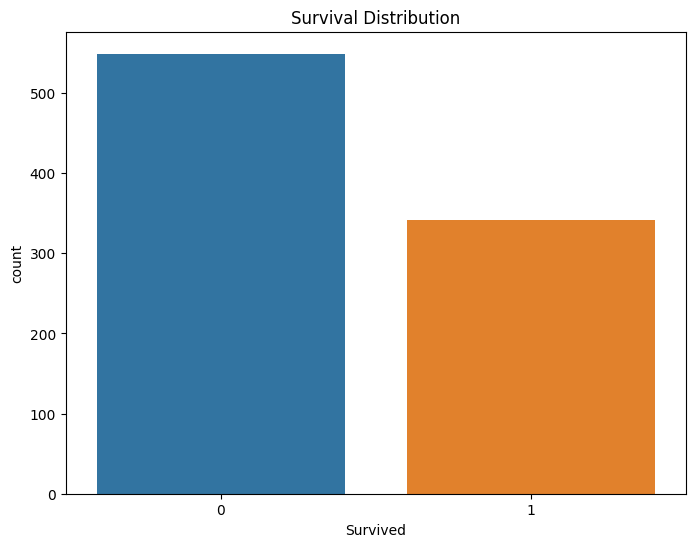

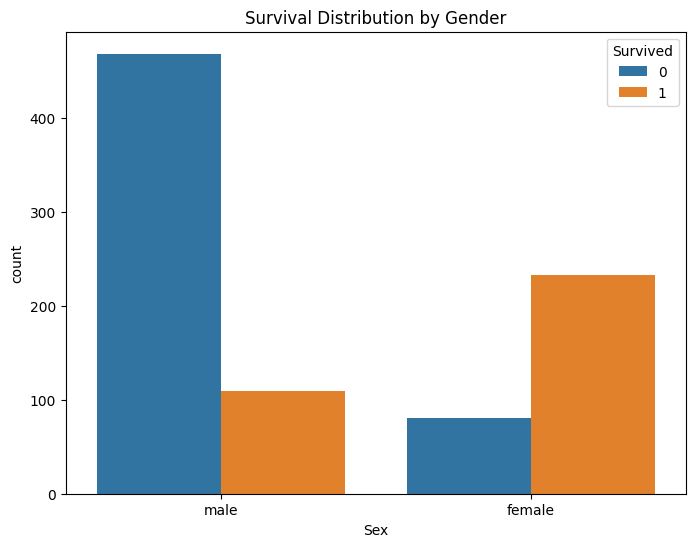

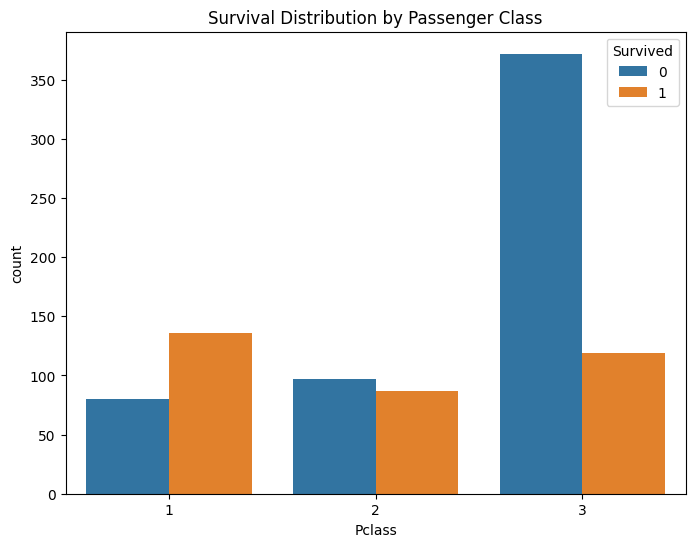

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

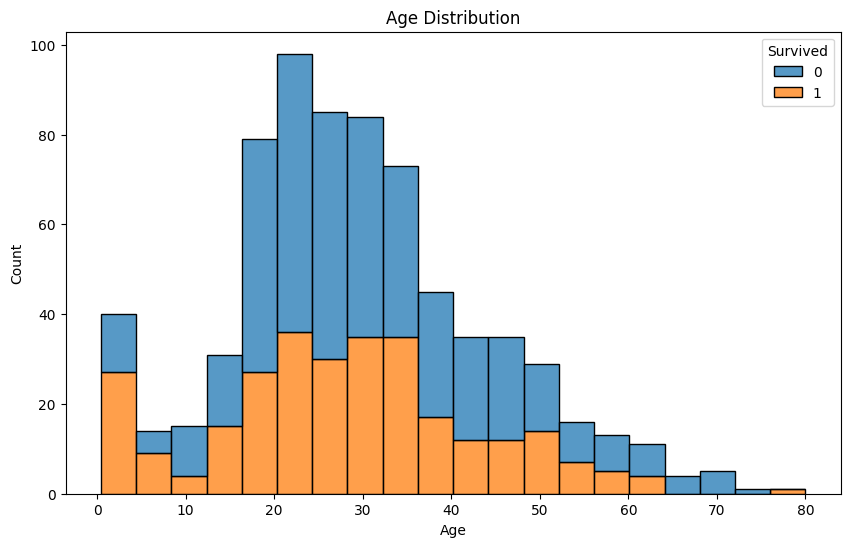

Accuracy: 0.8435754189944135

Confusion Matrix:
[[92 13]
 [15 59]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87       105
         1.0       0.82      0.80      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179

Submission file created successfully!


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

# Display the first few rows and basic information about the training data
print(train_data.head())
print(train_data.info())

# Exploratory Data Analysis (EDA)

# Survival rate
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=train_data)
plt.title('Survival Distribution')
plt.show()

# Survival rate by gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.title('Survival Distribution by Gender')
plt.show()

# Survival rate by Pclass
plt.figure(figsize=(8, 6))
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Survival Distribution by Passenger Class')
plt.show()

# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='Age', hue='Survived', multiple='stack')
plt.title('Age Distribution')
plt.show()

# Data Preprocessing and Feature Engineering

# Combine train and test data for preprocessing
full_data = pd.concat([train_data, test_data], sort=False)

# Create a title feature from Name
full_data['Title'] = full_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Group rare titles
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
full_data['Title'] = full_data['Title'].replace(rare_titles, 'Rare')
full_data['Title'] = full_data['Title'].replace('Mlle', 'Miss')
full_data['Title'] = full_data['Title'].replace('Ms', 'Miss')
full_data['Title'] = full_data['Title'].replace('Mme', 'Mrs')

# Create a family size feature
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1

# Create an is_alone feature
full_data['IsAlone'] = 0
full_data.loc[full_data['FamilySize'] == 1, 'IsAlone'] = 1

# Fill missing values
full_data['Embarked'] = full_data['Embarked'].fillna(full_data['Embarked'].mode()[0])
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())

# Create age bands
full_data['AgeBand'] = pd.cut(full_data['Age'], 5)

# Fill missing Age values with median age of their title group
full_data['Age'] = full_data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Drop unnecessary columns
full_data = full_data.drop(['Name', 'Ticket', 'Cabin', 'AgeBand'], axis=1)

# Convert categorical variables to numeric
full_data = pd.get_dummies(full_data, columns=['Sex', 'Title', 'Embarked'], drop_first=True)

# Split back into train and test
train_data = full_data[full_data['Survived'].notna()]
test_data = full_data[full_data['Survived'].isna()]

# Prepare the data for modeling
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the validation set
y_pred = rf_model.predict(X_val_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Prepare the test data for prediction
X_test = test_data.drop('Survived', axis=1)
X_test_scaled = scaler.transform(X_test)

# Make predictions on the test set
test_predictions = rf_model.predict(X_test_scaled)

# Create a submission file
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": test_predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")